In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from src import utils, plots, lossfunc, metrics, models

In [3]:
nn = torch.nn
F = torch.nn.functional

In [4]:
utils.set_seed(2022)
torch.backends.cudnn.benchmarks = False
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms(True)

In [5]:
# # hyperparams

# data
N = 21000
sigmas = [0.2, 0.8, 5]
alphas = [0.2, 0.8, 5]

# train
epochs = 500
batch_size = 512

# optim
lr = 1e-3
momentum = 0.99
weight_decay = 2e-3

In [6]:
def split_dataset(X, X_unif, X_ood):
    train, test, X_ood_unif, _, _, X_ood_test = train_test_split(
        X, X_unif, X_ood, test_size=0.1, random_state=2020)
    
    X_train = torch.from_numpy(train[:, :2]).float()
    y_train = torch.from_numpy(train[:, 2:]).long()
    X_test = torch.from_numpy(test[:, :2]).float()
    y_test = torch.from_numpy(test[:, 2:]).long()
    X_ood_unif = torch.from_numpy(X_ood_unif).float()
    X_ood_test = torch.from_numpy(X_ood_test).float()   
    
    return X_train, y_train, X_test, y_test, X_ood_unif, X_ood_test

In [7]:
# Generate training data
def generate_training_data(N, sigma):
    X, X_ood_unif = utils.generate_toy_dataset(N=N, sigma=sigma, use_torch=False)
    
    N = int(X.shape[0] / 4)
    X_ood_test = utils.generate_ood_multiclass(N=N, sigma=sigma, use_torch=False)
    
    X_train, y_train, X_test, y_test, X_ood_unif, X_ood_test = split_dataset(
        X, X_ood_unif, X_ood_test)
    
    return X_train, y_train, X_test, y_test, X_ood_unif, X_ood_test

In [8]:
# generate 3 datasets with varying std for training and testing
X_train, y_train, X_test, y_test, X_ood_train, X_ood_test = generate_training_data(
    N, sigmas[0])

train_data = [X_train, y_train, X_ood_train]
test_data = [X_test, y_test, X_ood_test]

In [9]:
datasets = train_data + test_data
datasets = [datasets[i] for i in [0, 1, 3, 4, 2, 5]]
y_ood_train = "#2077B4"
y_ood_test = "#FDE724"
datasets.insert(5, y_ood_train)
datasets.append(y_ood_test)
datasets += [np.vstack([X_test, X_ood_test]), np.vstack([y_test, np.ones((len(X_ood_test), 1))*3])]
datasets = [(datasets[i], datasets[i+1]) for i in range(len(datasets))[::2]]

Train:  torch.Size([56700, 2])
Test:  torch.Size([6300, 2])
Train OOD:  torch.Size([56700, 2])
Test OOD:  torch.Size([6300, 2])


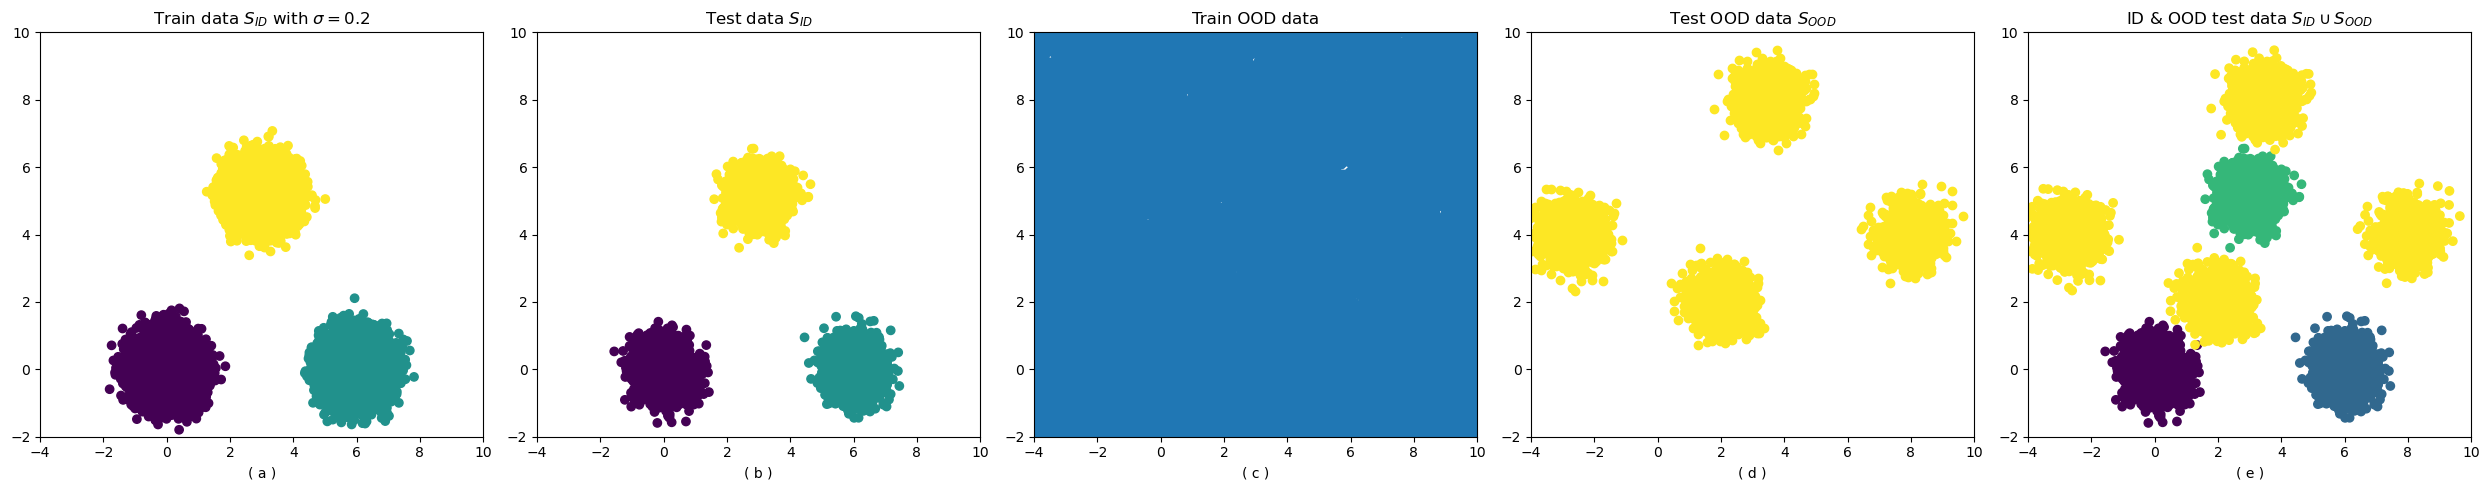

In [10]:
print("Train: ", X_train.shape)
print("Test: ", X_test.shape)
print("Train OOD: ", X_ood_train.shape)
print("Test OOD: ", X_ood_test.shape)

titles = ["Train data $S_{ID}$ with $\sigma=0.2$", 
          "Test data $S_{ID}$",
          "Train OOD data",
          "Test OOD data $S_{OOD}$",
         "ID & OOD test data $S_{ID} \cup S_{OOD}$"]
xlabels = ["( a )", "( b )", "( c )", "( d )", "( e )"]

fig, axs = plt.subplots(1, 5, figsize=(25, 5))
for ax, label, title, data in zip(axs, xlabels, titles, datasets):
    ax.set_ylim([-2, 10])
    ax.set_xlim([-4, 10])
    ax.set_xlabel(label)
    ax.set_title(title)
    x, y = data
    plots.plot_x(x, ax=ax, labels=y)

fig.tight_layout()

In [14]:
def train(model, opt, data, criterion, verbose=False):
    losses, accuracies = [], []
    X_train, y_train, X_ood_train = data
    n_minibatches = len(X_train) // batch_size
    model.train()
    for epoch in tqdm(range(epochs)):
        error = 0.0
        correct = 0.0
        for i in range(n_minibatches):
            x = X_train[i*batch_size: (i+1)*batch_size]
            y = y_train[i*batch_size: (i+1)*batch_size]
            y = y.view(-1)
            x_ood = X_ood_train[i*batch_size: (i+1)*batch_size]
            x_stack = torch.vstack([x, x_ood])
            logits = model(x_stack)
            loss, y_hat, _ = criterion(logits, y, len(x))
            correct += y_hat.eq(y.view_as(y_hat)).sum().item()
            error += loss.item() * len(x)

            opt.zero_grad()
            loss.backward()
            opt.step()

        losses.append(error / len(X_train))
        accuracies.append(correct / len(X_train))
        if epoch % 25 == 0:
            if verbose:
                print("Epoch: {} Loss: {}".format(epoch, np.mean(losses)))
    return losses, accuracies

In [15]:
def test(model, data, dropout=False):
    X_test, y_test, X_ood_test = data
    correct, correct_ood = 0.0, 0.0
    n_samples = 0.0
    model.eval()
    with torch.no_grad():
        for i in range(len(X_test) // batch_size):
            x = X_test[i*batch_size: (i+1)*batch_size]
            y = y_test[i*batch_size: (i+1)*batch_size]
            y = y.view(-1)
            x_ood = X_ood_test[i*batch_size: (i+1)*batch_size]
            x_stack = torch.vstack([x, x_ood])
            logits = utils.average_predictions(model, x_stack, y) if dropout else model(x_stack)
            y_hat = logits.argmax(dim=1, keepdim=True)
            correct += y.eq(y_hat[:batch_size].view_as(y)).sum().item()
            correct_ood += y.eq(y_hat[batch_size:].view_as(y)).sum().item()
            n_samples += batch_size

    print('Test data: Accuracy: {}/{} ({:.2f}%)\n'.format(
        correct, n_samples, 100. * correct / n_samples))
    print('Test OOD data: Accuracy: {}/{} ({:.2f}%)\n'.format(
        correct_ood, n_samples, 100. * correct_ood / n_samples))

In [16]:
# define network and optim
def construct_net(dropout=0):
    net = models.MLP(input_dim=2, hidden_dim=50, output_dim=3, dropout_rate=dropout)
    opt = torch.optim.SGD(net.parameters(), lr, momentum, weight_decay)
    return net, opt

In [17]:
def compute_metrics(model, X_test, X_ood_test):
    model.eval()
    with torch.no_grad():
        metrics_id = metrics.uncertainty_metrics(model(X_test).numpy())
        metrics_ood = metrics.uncertainty_metrics(model(X_ood_test).numpy())

    for string in ['confidence', 'entropy_of_conf', 'mutual_information']:
        y_test_in, y_test_ood = len(metrics_id[string]), len(metrics_ood[string])
        if string == "confidence":
            y_true = np.r_[np.ones(y_test_in), np.zeros(y_test_ood)]
            y_scores = np.r_[metrics_id[string], metrics_ood[string]]
        else:
            y_true = np.r_[np.ones(y_test_ood), np.zeros(y_test_in)]
            y_scores = np.r_[metrics_ood[string], metrics_id[string]]

        print("ROC values:\n {} = {},\n".format(string, roc_auc_score(y_true,  y_scores)))
    return metrics_id, metrics_ood

In [18]:
def plot_histogram(metrics_id, metrics_ood):
    f, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i, string in enumerate(['confidence', 'entropy_of_conf', 'mutual_information']):
#         ax[i].set_xscale('log')
        ax[i].hist(metrics_id[string], bins=np.linspace(0, 3, 25), label='Test', alpha=0.5)
        ax[i].hist(metrics_ood[string], bins=np.linspace(0, 3, 25), label='OoD', alpha=0.5)
        ax[i].legend()
        ax[i].set_title(string)

In [19]:
def plot_boundaries(model, X_test, y_test, X_ood_test, dropout=False):
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(25, 10))
    for ax in axs.flatten():
        ax.set_ylim([-2, 10])
        ax.set_xlim([-5, 10])

    y_ood_test_dummy = np.ones((len(X_ood_test), 1)) * 4
    test_sets = [[X_test, y_test], [X_ood_test, y_ood_test_dummy]]

    for i, test_set in enumerate(test_sets):
        X_te, y_te = test_set
        grid, x_coord, y_coord = utils.create_meshgrid(X_te)  # this creates a mesh grid
        test_data_grid =  torch.from_numpy(grid.astype(np.float32))
        model.eval()
        with torch.no_grad():
            if dropout:
                logits = utils.average_predictions(model, test_data_grid, y_te, n_classes=3, n_models=30)
            else:
                logits = model(test_data_grid)
            logits = np.asarray(logits)
            X_te = np.asarray(X_te)
            y_te = np.asarray(y_te)
            plots.plot_net(logits, X_te, y_te, x_coord, y_coord, axs[i], fig, sigma=sigmas[i])
    fig.tight_layout()

### Create network, train and plot metrics: CrossEntropy Baseline

In [20]:
# construct network
model, opt = construct_net()

In [21]:
# Train the networks
losses, accuracies = train(model, opt, train_data, lossfunc.cross_entropy)

  0%|          | 0/500 [00:00<?, ?it/s]

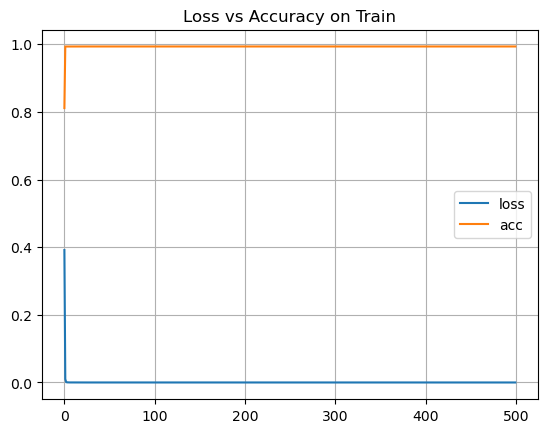

In [22]:
plots.plot_train_stats(epochs, losses, accuracies)

In [23]:
test(model, test_data)

Test data: Accuracy: 6144.0/6144.0 (100.00%)

Test OOD data: Accuracy: 2088.0/6144.0 (33.98%)



In [24]:
metrics_id, metrics_ood = compute_metrics(model, X_test, X_ood_test)

ROC values:
 confidence = 0.7213473167044596,

ROC values:
 entropy_of_conf = 0.7212145880574452,

ROC values:
 mutual_information = 0.7093578735197783,



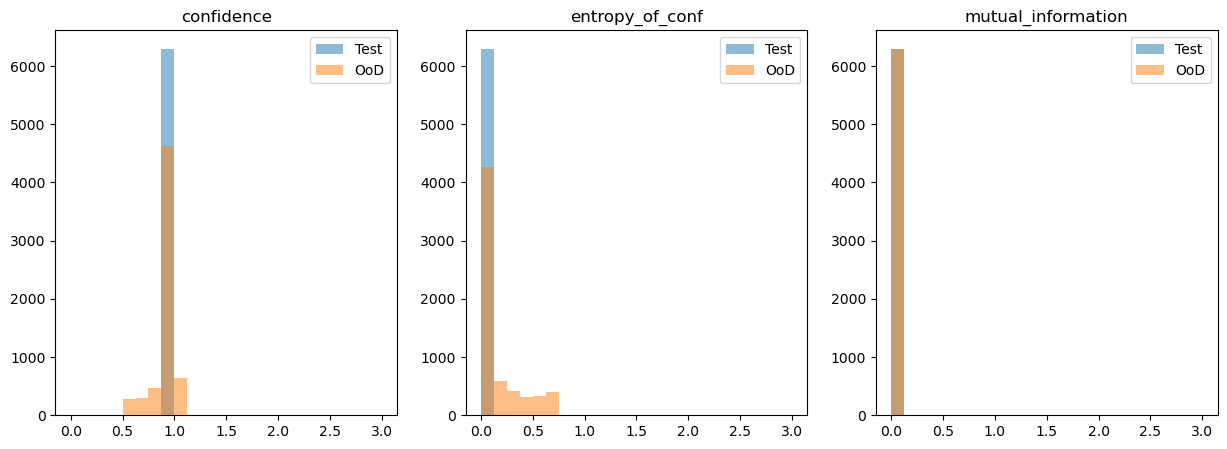

In [25]:
plot_histogram(metrics_id, metrics_ood)

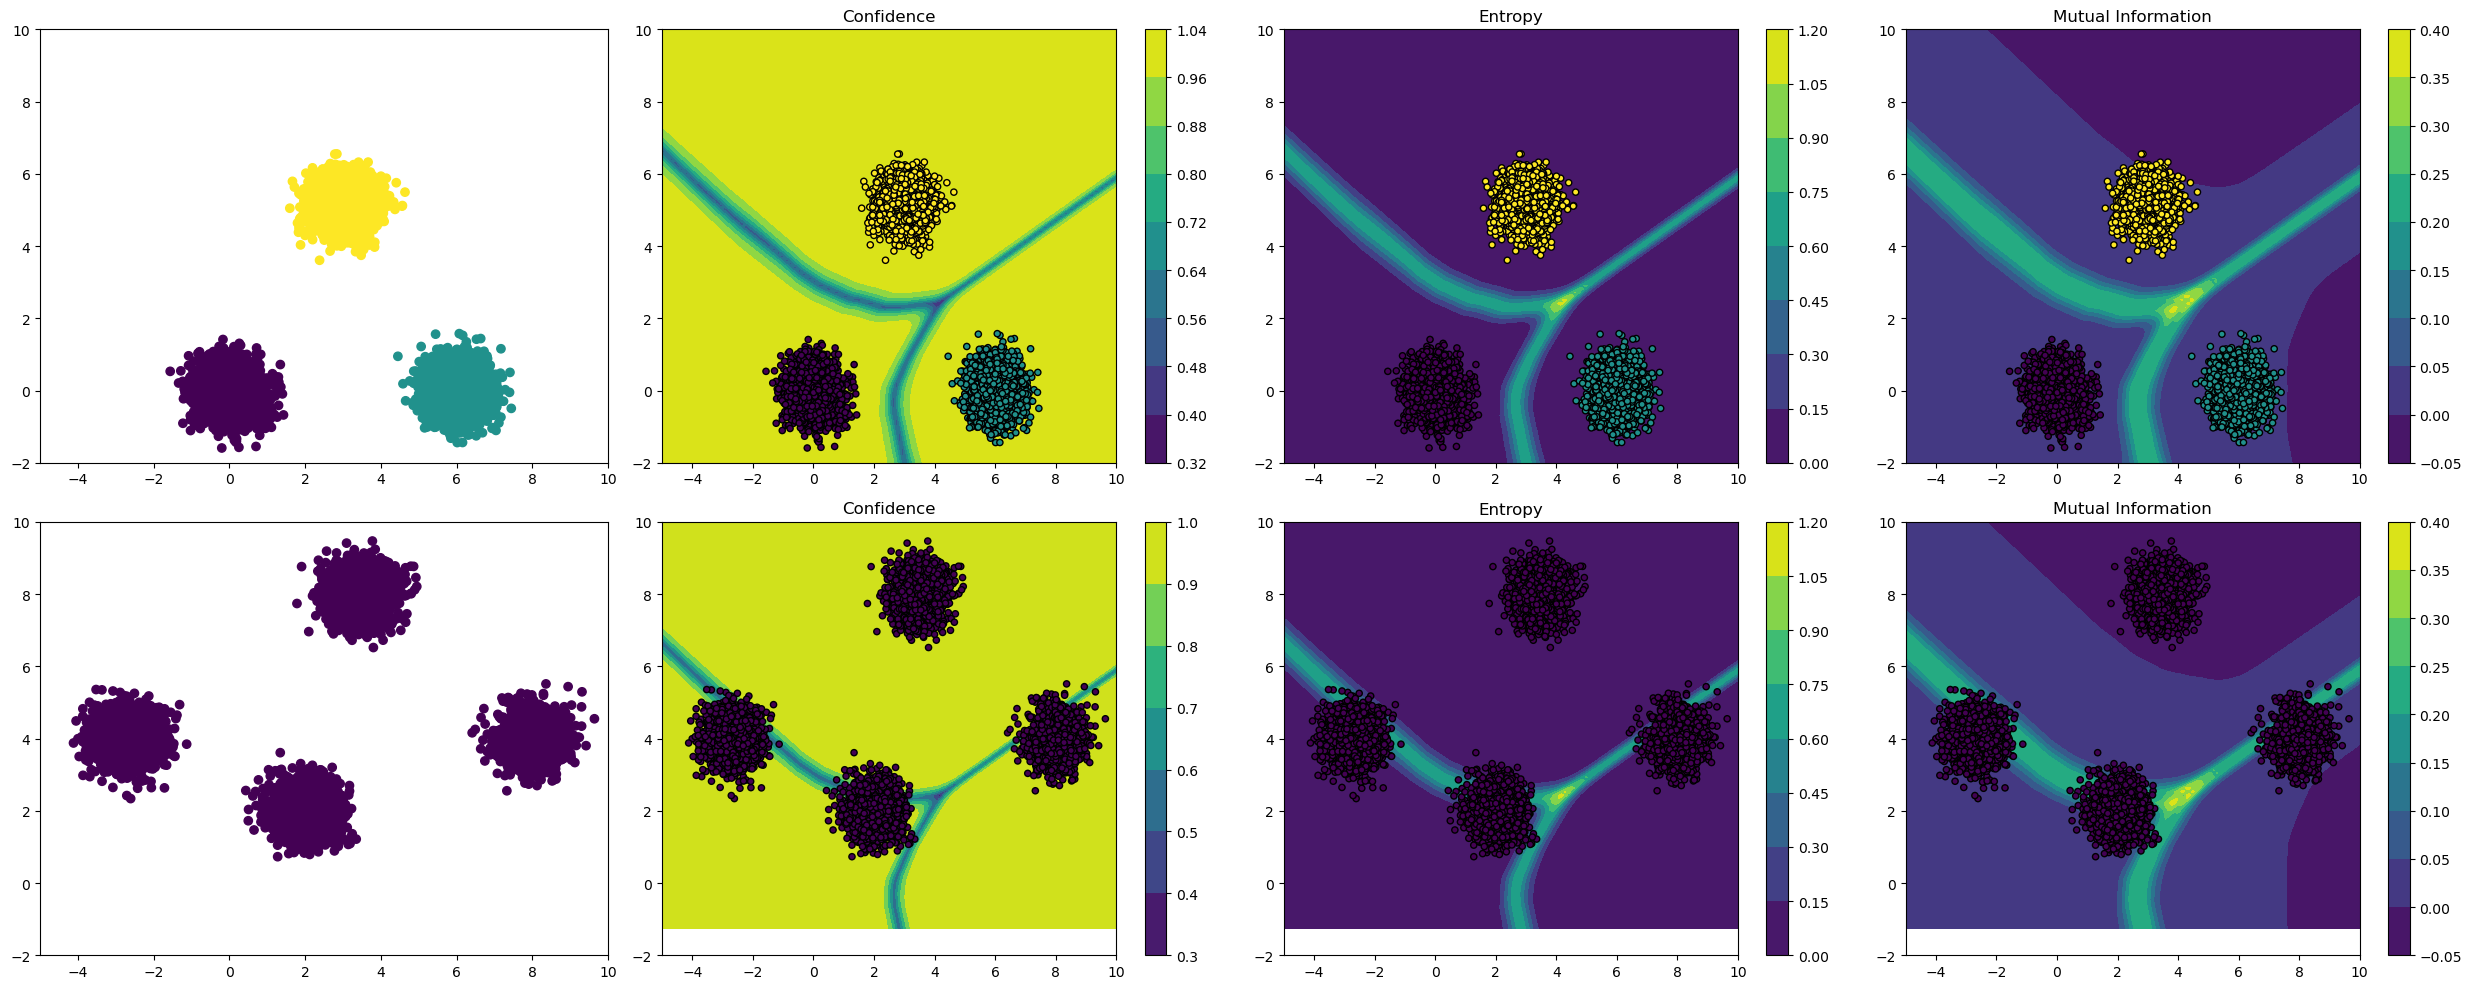

In [26]:
plot_boundaries(model, X_test, y_test, X_ood_test)

### Create network, train and plot metrics: CrossEntropy + MCD

In [27]:
# construct network
model, opt = construct_net(dropout=0.1)

In [28]:
# train and test the model
losses, accuracies = train(model, opt, train_data, lossfunc.cross_entropy)

  0%|          | 0/500 [00:00<?, ?it/s]

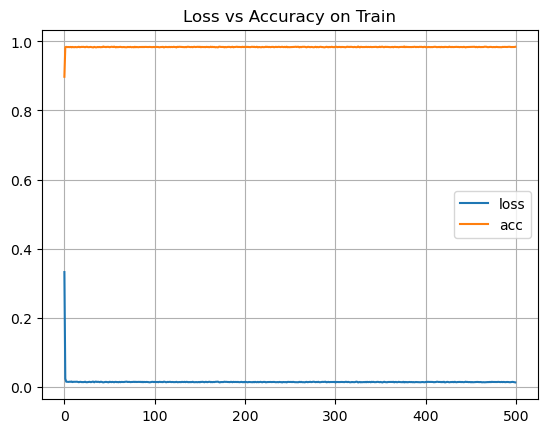

In [29]:
plots.plot_train_stats(epochs, losses, accuracies)

In [30]:
test(model, test_data, dropout=True)

Test data: Accuracy: 6144.0/6144.0 (100.00%)

Test OOD data: Accuracy: 2072.0/6144.0 (33.72%)



In [31]:
metrics_id, metrics_ood = compute_metrics(model, X_test, X_ood_test)

ROC values:
 confidence = 0.7062600655076846,

ROC values:
 entropy_of_conf = 0.705803476946334,

ROC values:
 mutual_information = 0.7009300327538421,



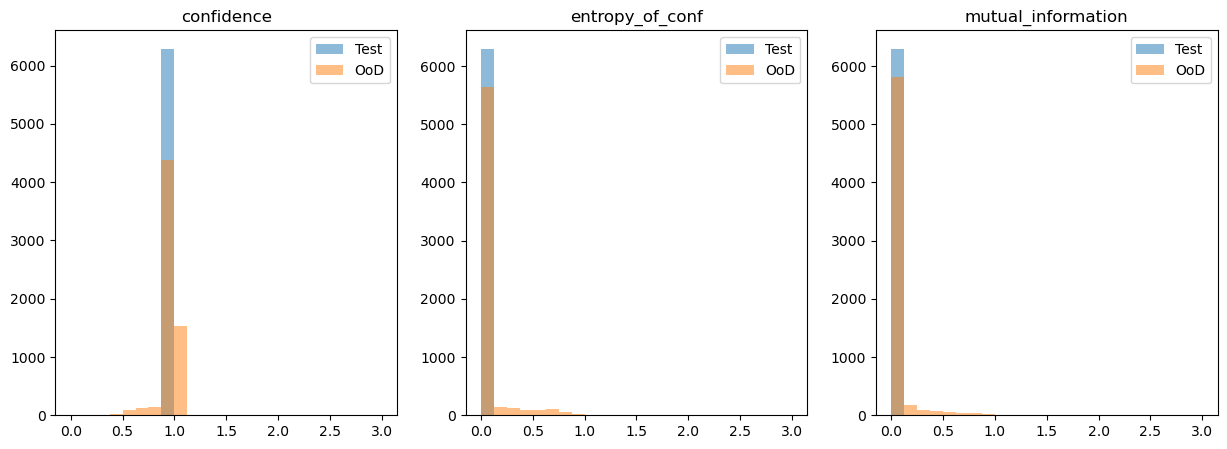

In [32]:
plot_histogram(metrics_id, metrics_ood)

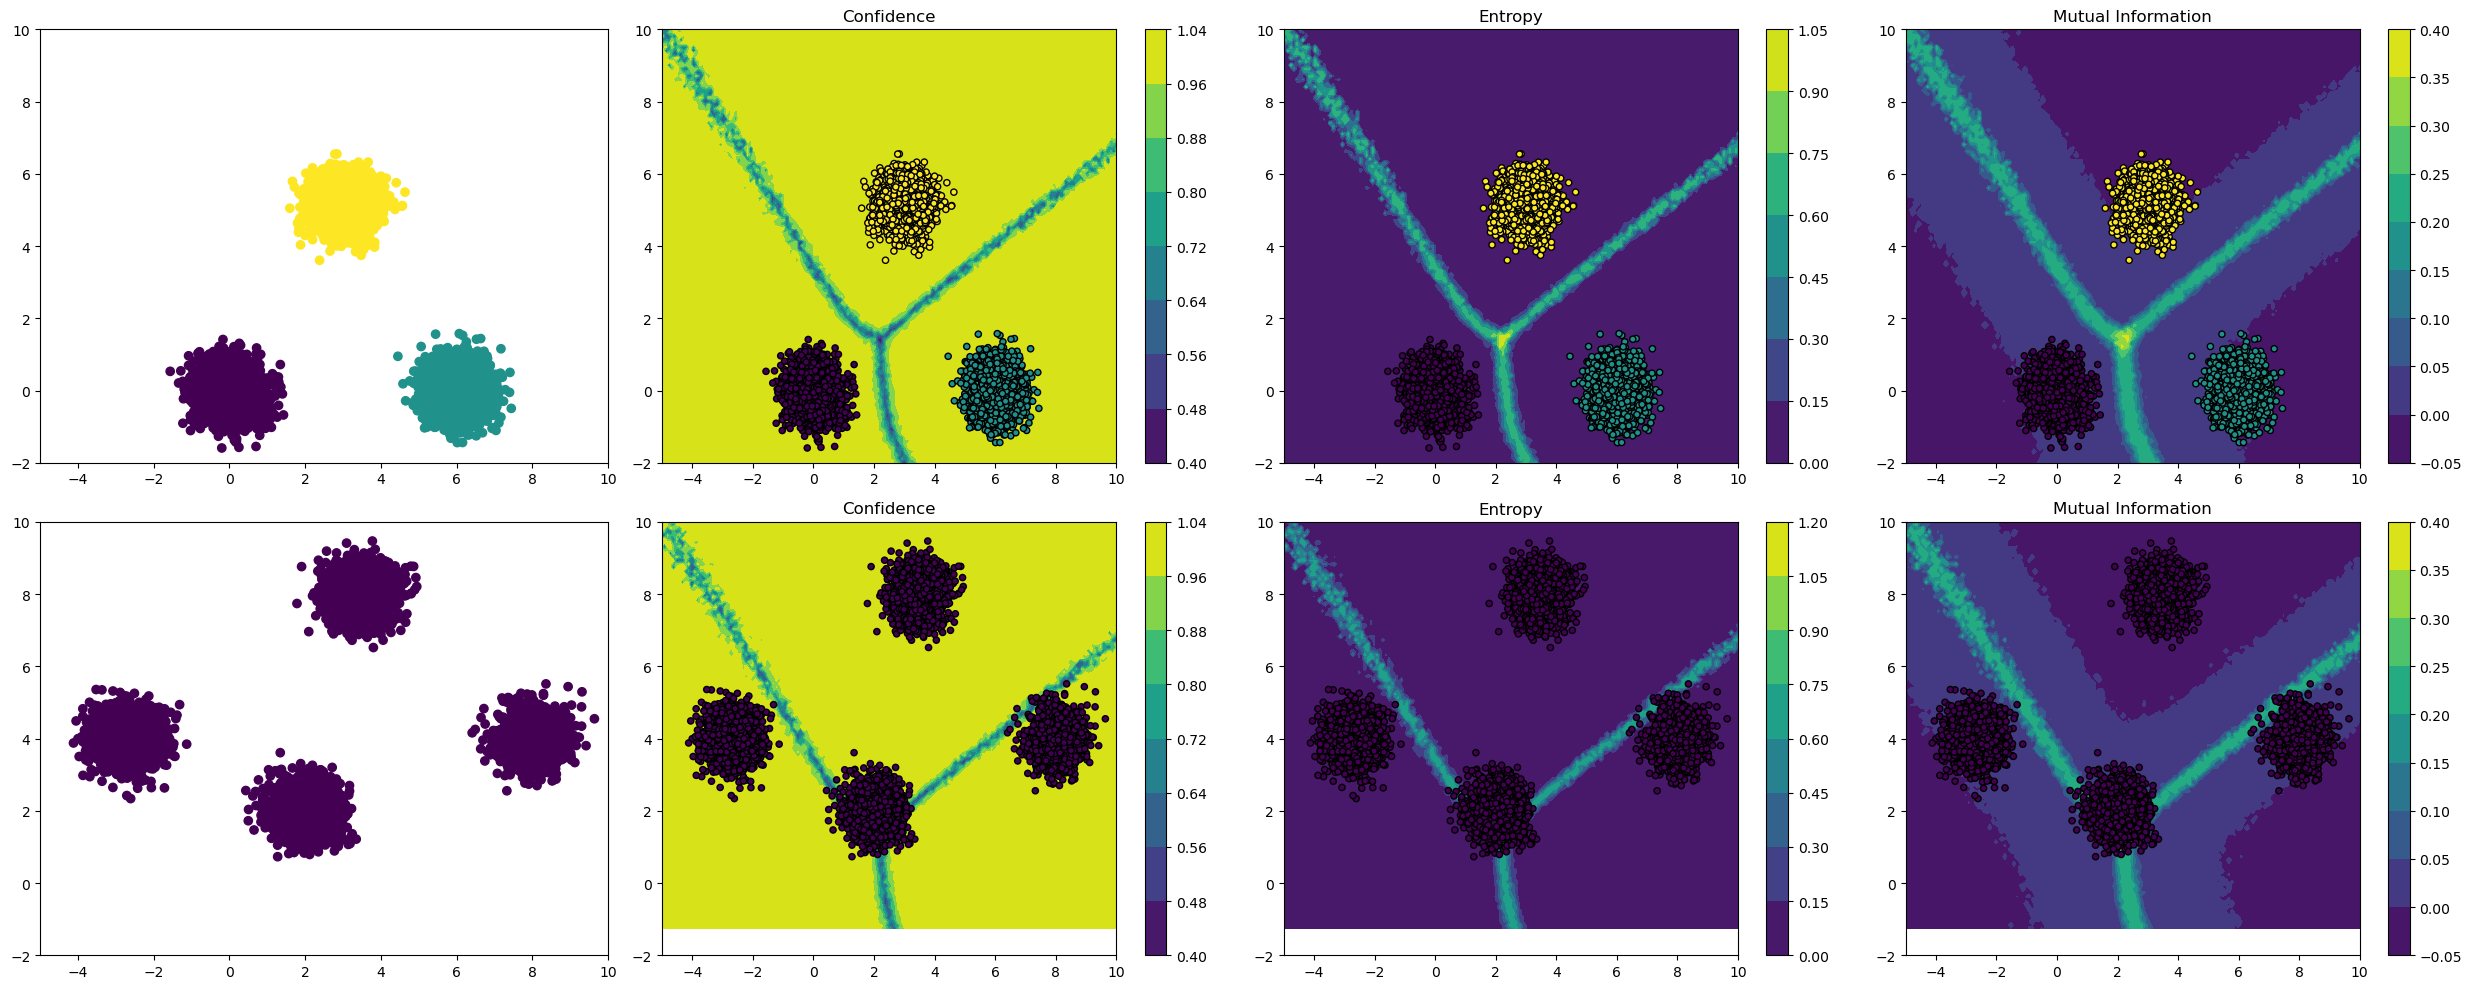

In [33]:
plot_boundaries(model, X_test, y_test, X_ood_test, dropout=True)

### Create network, train and plot metrics: Contrastive Regularised

In [34]:
model, opt = construct_net()

In [35]:
# train and test the model
losses, accuracies = train(model, opt, train_data, lossfunc.contrastive_regularized)

  0%|          | 0/500 [00:00<?, ?it/s]

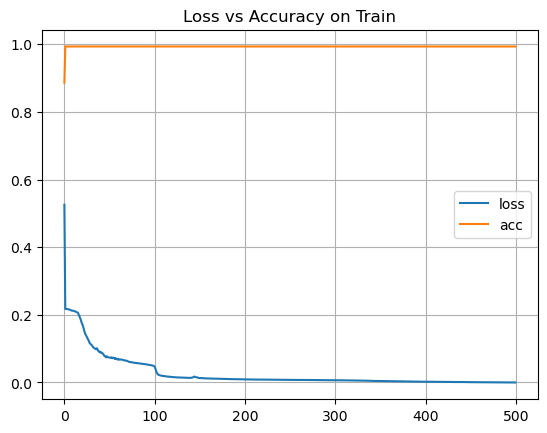

In [36]:
lossespos = np.abs(losses)
lossesmax = np.max(lossespos)
plots.plot_train_stats(epochs, lossesmax-lossespos, accuracies)

In [37]:
test(model, test_data)

Test data: Accuracy: 6144.0/6144.0 (100.00%)

Test OOD data: Accuracy: 2068.0/6144.0 (33.66%)



In [38]:
metrics_id, metrics_ood = compute_metrics(model, X_test, X_ood_test)

ROC values:
 confidence = 0.999991761148904,

ROC values:
 entropy_of_conf = 0.9999918619299571,

ROC values:
 mutual_information = 0.9999936255983874,



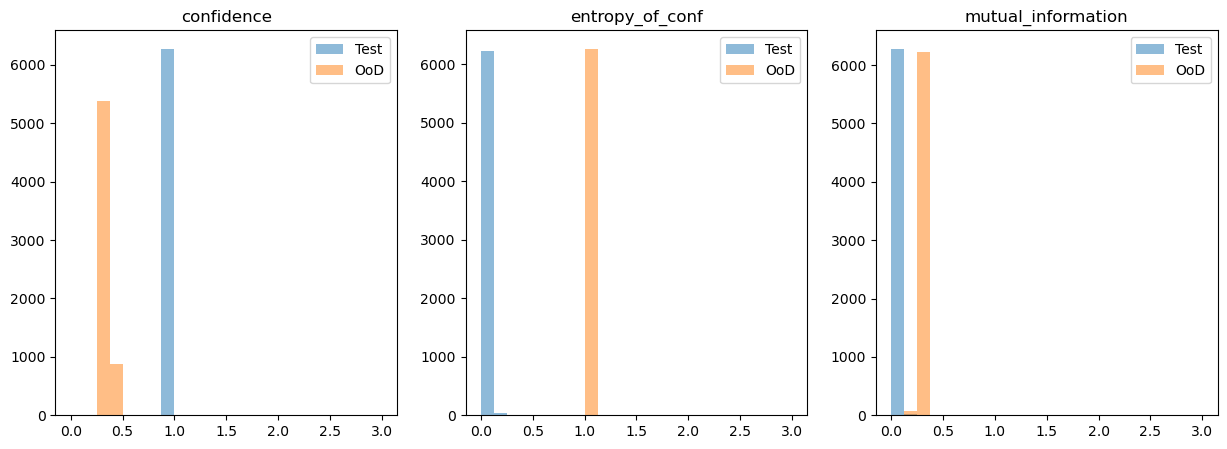

In [39]:
plot_histogram(metrics_id, metrics_ood)

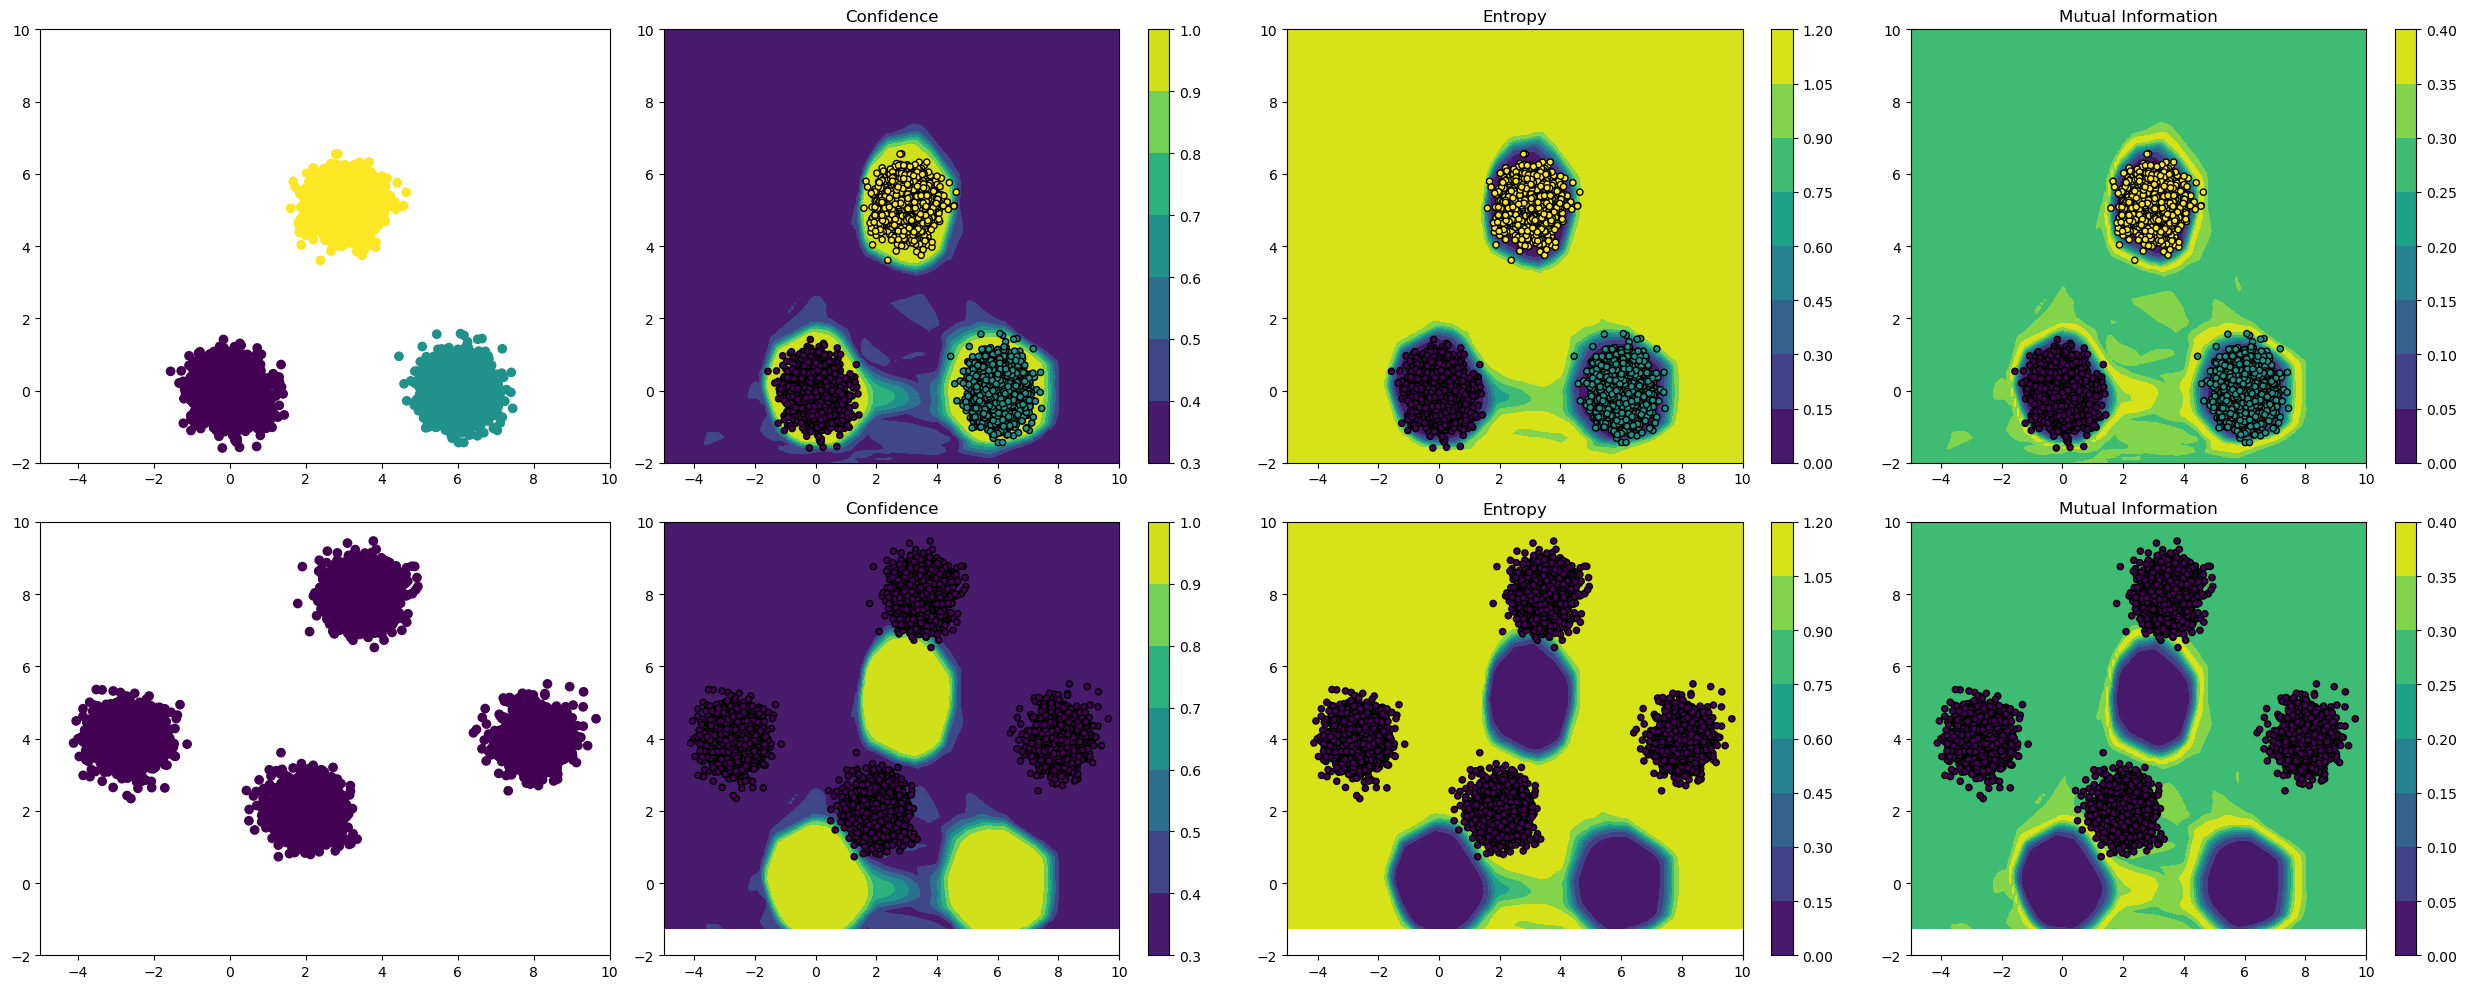

In [40]:
plot_boundaries(model, X_test, y_test, X_ood_test)

### Create network, train and plot metrics: Contrastive Ranking

In [41]:
model, opt = construct_net()

In [42]:
losses, accuracies = train(model, opt, train_data, lossfunc.contrastive_ranking)

  0%|          | 0/500 [00:00<?, ?it/s]

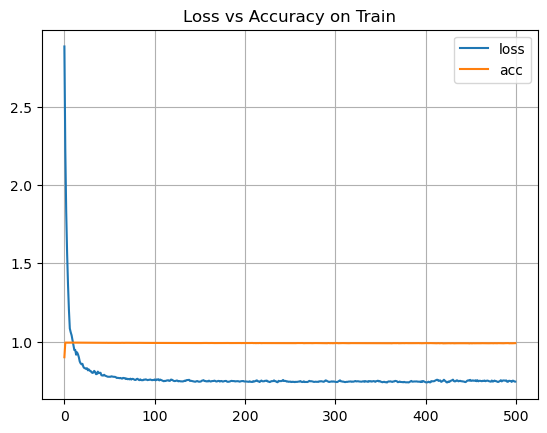

In [43]:
plots.plot_train_stats(epochs, losses, accuracies)

In [44]:
# test the model
test(model, test_data)

Test data: Accuracy: 6111.0/6144.0 (99.46%)

Test OOD data: Accuracy: 1977.0/6144.0 (32.18%)



In [45]:
metrics_id, metrics_ood = compute_metrics(model, X_test, X_ood_test)

ROC values:
 confidence = 0.9962092970521541,

ROC values:
 entropy_of_conf = 0.9958510707986898,

ROC values:
 mutual_information = 0.9959954648526077,



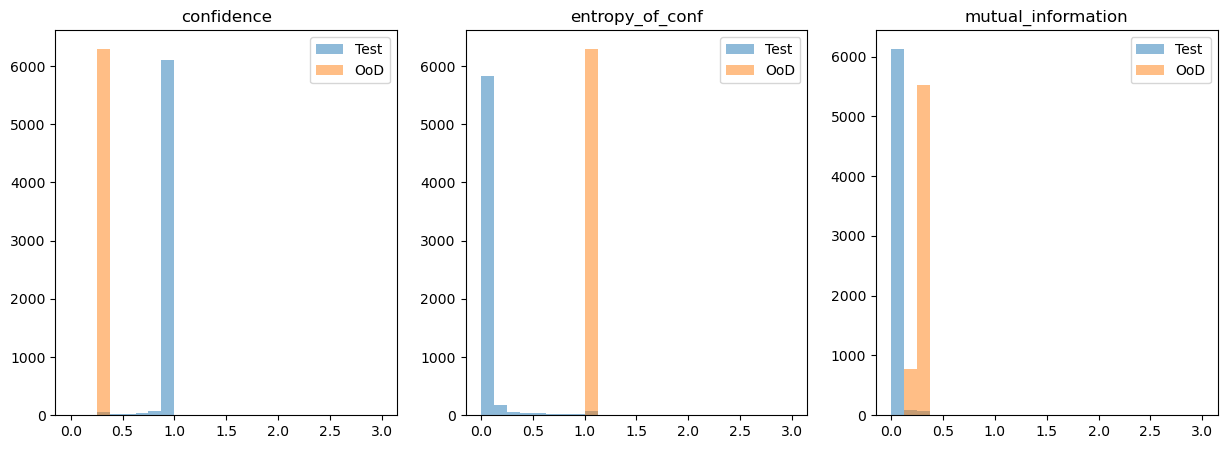

In [46]:
plot_histogram(metrics_id, metrics_ood)

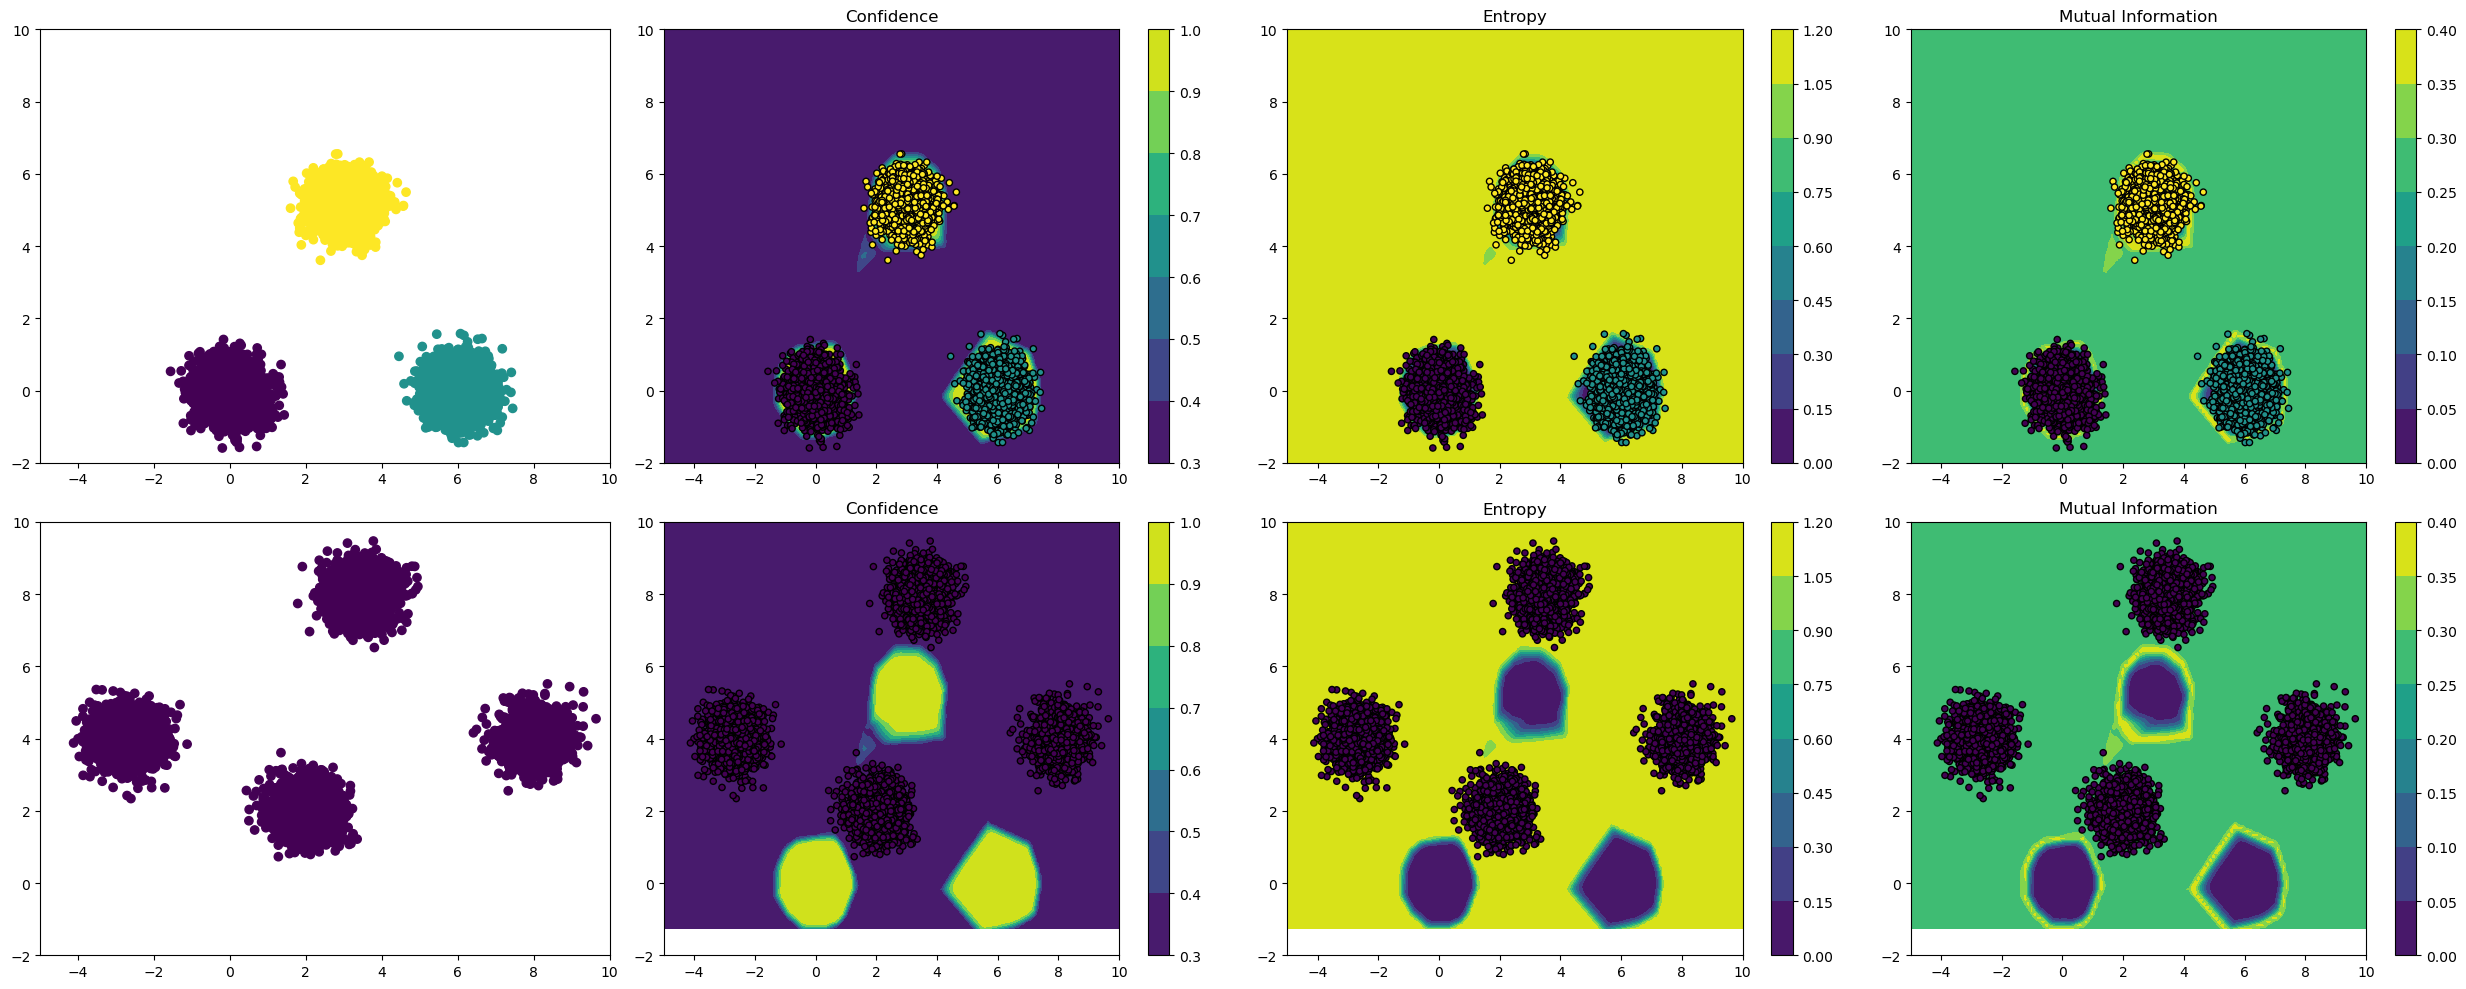

In [47]:
plot_boundaries(model, X_test, y_test, X_ood_test)